# Create Helper Functions to Process Geospatial data to the Police Beat

Gabe Morrison

# Read Data

In [1]:
#library imports: 
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot
import libpysal as lp
import shapely

In [68]:
#The below function reads in the spatial data and sets a CRS. CRS (coordinate reference systems) determine 
# how spatial 3D data (because globe is round) get converted into a 2D plane. 

def read_spatial(path):
    '''
    Function to read spatial data and converts to ESPG 3435
    Input: path to the data file
    Output: a gpd object 
    '''
    file=gpd.read_file(path)
    file=file.to_crs("EPSG:3435")
    print(path, file.crs)
    return file

In [69]:
beats = read_spatial("../raw_data/Boundaries - Police Beats (current).geojson")
#l = read_spatial("../raw_data/CTA_RailStations")
#bus = read_spatial("../raw_data/CTA_BusStops")
#metra = read_spatial("../raw_data/Metra_Stations")
#streets = read_spatial("../raw_data/Street Center Lines.geojson")
#bus_data = read_spatial("../intermediate_data/bus_geog")

../raw_data/Boundaries - Police Beats (current).geojson EPSG:3435
../raw_data/CTA_RailStations epsg:3435
../raw_data/CTA_BusStops EPSG:3435
../raw_data/Metra_Stations epsg:3435
../raw_data/Street Center Lines.geojson EPSG:3435
../intermediate_data/bus_geog EPSG:3435


In [70]:
#rest = bus_data[bus_data["category"]=="restaurant"]
#bar = bus_data[bus_data["category"]=="bar"]
#business = bus_data[bus_data["category"]=="business"]
#daycare = bus_data[bus_data["category"]=="daycare"]
#entertainment = bus_data[bus_data["category"]=="entertainment"]


# Aggregate Point Data to Beats

In [5]:
#Function to add point data to the beats polygon dataset
#Specifically, this function first performs a "spatial join" each point in the "other dataset" (ex bus station)
#gets the name of the police beat it is in in a new column ("beat_num")
#Then I group by and count the number of points in each beat and join that to the beat dataset


def join_to_beats(polygon_data, poly_unique_id, other_file, new_column_name):
    '''
    A function that creates a new beats gpd with an updated column 
        to count the number of points from the other_file 
    Inputs:
        polygon_data (gpd): the beats gpd (as a polygon)
        poly_unique_id (string): the unique identifier of the polygon spatial data
        other_file (gpd): another point-based gpd. The number of points in each beat will 
                    be added to the beats as a new column
        new_column_name (string): the name of the column to be added to the beats dataframe
    Output:
        the polygon_data dataframe updated with the new column
    Note: .size suggestion from here: https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    '''
    spatial_join = gpd.sjoin(other_file, 
                             polygon_data[[poly_unique_id, "geometry"]], 
                             how="inner", 
                             op='intersects')
    count = spatial_join.groupby(poly_unique_id).size().reset_index(name=new_column_name)
    updated_polygon_data = polygon_data.merge(count, on=poly_unique_id, how="left")
    updated_polygon_data[new_column_name].fillna(0, inplace=True)
    return updated_polygon_data

In [71]:
#Run above function to add point data to the beats
#beats = join_to_beats(beats, "beat_num", l, "count_l_stops")
#beats = join_to_beats(beats, "beat_num", bus, "count_bus_stops")
#beats = join_to_beats(beats, "beat_num", metra, "count_metra_stops")
#beats = join_to_beats(beats, "beat_num", rest, "count_restaurants")
#beats = join_to_beats(beats, "beat_num", bar, "count_bars")
#beats = join_to_beats(beats, "beat_num", daycare, "count_daycares")
#beats = join_to_beats(beats, "beat_num", entertainment, "count_entertainment")
#beats = join_to_beats(beats, "beat_num", business, "count_businesses")




# Handle Street Data (to compute av street distance)

In [74]:
#Filter Out non-pedestrian Streets (ie highways):
#Syntax help: https://www.kite.com/python/answers/how-to-filter-a-pandas-dataframe-with-a-list-by-%60in%60-or-%60not-in%60-in-python

#streets_do_not_want = ["ER", "EXPY", "HWY", "PKWY", "ORD", "XR", "TOLL"]
#street_filter = ~streets.street_typ.isin(streets_do_not_want)
#streets = streets[street_filter]

In [75]:
#Spatial operation to get all strings into exactly one polygon
#Help on overlay code here::https://stackoverflow.com/questions/60794994/geopandas-split-lines-at-intersection-with-polygons-retain-polygon-id-in-new
#Help with renaming after groupby: https://stackoverflow.com/questions/44416287/renaming-columns-after-group-by-and-sum-in-pandas-dataframe

#First: separate line segments so that they fall into exactly one police beat
#Second: same spatial join as above
#Third: Compute distance (in feet) of each segment
#Fourth/Fifth: Keep only the beat_num and distance columns
#Sixth:group by beat and sum all distances in the beat
#seventh:Add the column with the summarized distances back to the beat dataset


#streets_separated = gpd.overlay(streets, beats, how="union", keep_geom_type=False).explode().reset_index(drop=True)
#streets_separated = gpd.sjoin(streets_separated, 
#                             beats[["beat_num", "geometry"]], 
#                             how="inner", 
#                             op='intersects')
#streets_separated["distance"]= streets_separated["geometry"].length
#streets_separated = streets_separated[["beat_num_left", "distance"]]
#streets_separated.rename(columns={"beat_num_left":"beat_num"}, inplace=True)
#streets_separated = streets_separated.groupby("beat_num").sum("distance").reset_index().rename(columns={'distance':'road_distance_ft'})
#beats = beats.merge(streets_separated, how ="left", on="beat_num")

# Crosswalk for ACS Block data

Goal of below section is to (1) create a crosswalk between blocks and beats and (2) use it to get total population (and maybe future data too) to the beat scale. 

The assumption is an equal distribution of population within a block which is obviously not a perfect assumption but super unreasonable either. I make this by subdividing the blocks to "sub_blocks" which are blocks divided by beats. That is, if a block is fully in a beat, the it remains the same as a sub_block. If a block is split into two beats, that block becomes two sub_blocks. I then compute the area of the sub_block/area of block (just 1 if the block is unsplit). Now, one can multiply this column by a population measure (ex Total population) and aggregate by block to estimate the measure by block. I write a function to do this.

In [9]:
blocks = read_spatial("../raw_data/Boundaries - Census Blocks - 2010.geojson")

../raw_data/Boundaries - Census Blocks - 2010.geojson epsg:4326


In [10]:
#Create Crosswalk From Block to Beat:
#Read Block spatial data and population by block
#Then join the two
pop_10 = pd.read_csv("../raw_data/Population_by_2010_Census_Block.csv", 
                     dtype={"CENSUS BLOCK FULL":"object", "CENSUS BLOCK":"object"})
blocks = blocks.merge(pop_10, left_on="geoid10", right_on="CENSUS BLOCK FULL", how="left")

In [11]:
#Some data didn't match:
blocks.isna().sum()

statefp10             0
name10                0
blockce10             0
tract_bloc            0
geoid10               0
tractce10             0
countyfp10            0
geometry              0
CENSUS BLOCK         20
CENSUS BLOCK FULL    20
TOTAL POPULATION     20
dtype: int64

In [12]:
#Fill NA with the total average and select on population and id columns
#Select only columns of interest: 
blocks = blocks[["geoid10", "TOTAL POPULATION", "geometry"]]

#Fill NAs: 
mean_pop = blocks["TOTAL POPULATION"].mean()
blocks.fillna(mean_pop, inplace=True)

#Check nas filled:
blocks.isna().sum()


geoid10             0
TOTAL POPULATION    0
geometry            0
dtype: int64

In [13]:
blocks.shape

(46357, 3)

In [14]:
#Get full block area and area within each beat:

#Full block area
blocks["full_block_area"]=blocks.area

#Subdivide to in each beat:
blocks_exploded = gpd.overlay(blocks, beats, how="union", keep_geom_type=False).explode().reset_index(drop=True)


<ipython-input-14-dcefc52f8a81>:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  blocks["full_block_area"]=blocks.area


In [15]:
#Note that there are a number of sub_blocks here too 
blocks_exploded.isna().sum()

geoid10                8823
TOTAL POPULATION       8823
full_block_area        8823
beat                   9183
beat_num               9183
district               9183
sector                 9183
count_l_stops          9183
count_bus_stops        9183
count_metra_stops      9183
count_restaurants      9183
count_bars             9183
count_daycares         9183
count_entertainment    9183
count_businesses       9183
road_distance_ft       9183
geometry                  0
dtype: int64

In [16]:
blocks_exploded.shape

(81119, 17)

In [17]:
blocks_exploded["na_geoid"] = blocks_exploded["geoid10"].isna()
blocks_exploded["na_beat"]=blocks_exploded["beat"].isna()

<AxesSubplot:>

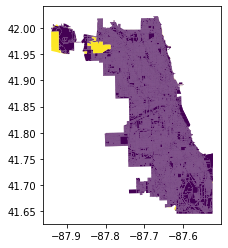

In [18]:
#blocks_exploded.plot(column="na_geoid")

<AxesSubplot:>

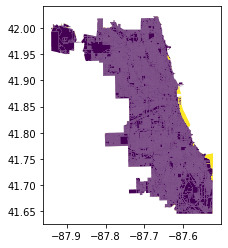

In [19]:
#blocks_exploded.plot(column="na_beat")

Location of missing data: Some tracts are missing beat data if they are actually in Lake Michigan. Some beats are missing tract data if they are on the edges of Chicago (ie part of O'Hare or Norridge/Harrwood Heights). 

Solution: I throw all of this data out: we are looking for Chicago Police beats and these do not quality

In [20]:
blocks_exploded = blocks_exploded.dropna()

In [21]:
#Area of sub-block:
blocks_exploded["sub_block_area"]=blocks_exploded.area
#Percentage of area of full block:
blocks_exploded["pct_of_full_block"]=blocks_exploded["sub_block_area"]/blocks_exploded["full_block_area"]

<ipython-input-21-005d56ed7fab>:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  blocks_exploded["sub_block_area"]=blocks_exploded.area
/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [22]:
conversion_df = blocks_exploded[["geoid10", "beat_num", "pct_of_full_block"]]

In [23]:
def convert_block_to_beat(df_at_block, col_name):
    '''
    Function that converts data at the 2010 block scale to the Chicago beat scale 
    Note that this excludes census tracts not in beats as well as beats outside of Chicago prop
    Inputs:
        df_at_block(df): dataframe at the Chicago 2010 block scale
            Note: this df must have blocks identified with column geoid10
        col_name (string): the column of data to be converted to the beat scale
    Output:
        beats(df): the previous beats dataframe but with a new column for the aggregated data added
    '''
    df_at_block=df_at_block[["geoid10", col_name]]
    block_df = pd.merge(conversion_df, df_at_block, how="left", on="geoid10")
    block_df[col_name]=block_df["pct_of_full_block"] * block_df[col_name]
    
    beats_df = block_df.groupby("beat_num").agg({col_name:"sum"})
    beats2 = pd.merge(beats, beats_df, how = "left", on = "beat_num")
    return beats2

In [24]:
#beats = convert_block_to_beat(blocks, "TOTAL POPULATION")
#beats

,beat,beat_num,district,sector,geometry,count_l_stops,count_bus_stops,count_metra_stops,count_restaurants,count_bars,count_daycares,count_entertainment,count_businesses,road_distance_ft,TOTAL POPULATION
0,1,1713,17,1,"MULTIPOLYGON (((-87.70473 41.97577, -87.70472 ...",3.0,26.0,0.0,63.0,9.0,6.0,1.0,92.0,0.548141,13283.675102
1,0,3100,31,0,"MULTIPOLYGON (((-87.83365 41.97535, -87.83366 ...",0.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,1.616425,132.169445
2,5,1651,16,5,"MULTIPOLYGON (((-87.90684 41.97656, -87.91070 ...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076889,0.000000
3,1,1914,19,1,"MULTIPOLYGON (((-87.64492 41.96973, -87.64431 ...",0.0,43.0,0.0,48.0,6.0,4.0,3.0,76.0,0.411940,10907.560081
4,1,1915,19,1,"MULTIPOLYGON (((-87.63724 41.96599, -87.63644 ...",0.0,44.0,0.0,25.0,5.0,2.0,2.0,53.0,0.834758,12773.552922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,1,0314,03,1,"MULTIPOLYGON (((-87.58879 41.78612, -87.58844 ...",0.0,32.0,1.0,4.0,0.0,2.0,0.0,31.0,0.472742,6933.307154
273,2,0825,08,2,"MULTIPOLYGON (((-87.67917 41.78656, -87.67912 ...",0.0,24.0,0.0,25.0,1.0,1.0,0.0,44.0,0.590103,7765.801695
274,1,0313,03,1,"MULTIPOLYGON (((-87.60854 41.78583, -87.60808 ...",0.0,29.0,0.0,11.0,0.0,3.0,0.0,26.0,0.410752,5786.813143
275,2,0823,08,2,"MULTIPOLYGON (((-87.69354 41.78458, -87.69354 ...",0.0,46.0,0.0,68.0,6.0,6.0,0.0,135.0,0.977021,22290.925452


<AxesSubplot:>

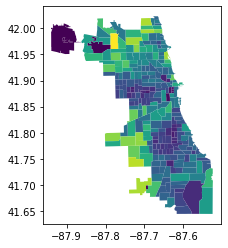

In [25]:
#beats.plot(column="TOTAL POPULATION")

In [26]:
#Calculate distance to nearest police station/hospital:

#police_station = read_spatial("../raw_data/PoliceStationsDec2012")
#hospital = read_spatial("../raw_data/Hospitals")
#beats["centroid"]=beats.centroid

#shapely.ops.nearest_points(beats_cent, police_station)

../raw_data/PoliceStationsDec2012 EPSG:4326
../raw_data/Hospitals EPSG:4326


<ipython-input-26-1cbcd8b55ff4>:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  beats["centroid"]=beats.centroid


# Distance to Nearest Point: 

In [27]:
def dist_to_nearest(df1, df2, geom_col_df1, df1_new_col_name):
    '''
    calculates the distance from the points in df1 to nearest point in df2
    df1: point geodataframe
    df2: point geodataframe
    
    
    '''
    dist = df1[geom_col_df1].apply(lambda g: df2.distance(g))
    df1[df1_new_col_name] = dist.min(axis=1)
    return df1


<ipython-input-27-e23420be08c8>:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist = df1[geom_col_df1].apply(lambda g: df2.distance(g))
<ipython-input-27-e23420be08c8>:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dist = df1[geom_col_df1].apply(lambda g: df2.distance(g))


In [ ]:
#beats = dist_to_nearest(beats, police_station, "centroid", "dist_to_police")
#beats = dist_to_nearest(beats, hospital, "centroid", "dist_to_hospital")

# Spatial Lag:

In [63]:
import libpysal as lp

def compute_spatial_lag(gpd, column, new_col_name, time_indentifier):
    '''
    Creates a new column in the dataframe that calculates the spatial lag
    Spatial lag defined as the average of the neighbors
    Neighbors are defined using first order queen contiguity
    
    Inputs:
        gpd - a geopandas dataframe
        column - the column on which to great the spatial lag
        new_col_name - the name of the spatial lag column
        time-identifier - a column that identifies the time periods in the data
    Ouput:
        gpd - the updated dataframe with the new columns
    
    '''
    times = list(gpd[time_indentifier].unique())
    
    all_time_gpds = []
    for time in times:
        gpd_one_period = gpd.loc[gpd[time_indentifier]==time]
        weights_matrix = lp.weights.Queen.from_dataframe(gpd_one_period)
        weights_matrix.transform = "r"
        data_series = gpd_one_period[column]
        gpd_one_period[new_col_name] = lp.weights.lag_spatial(weights_matrix, gpd_one_period[column])
        all_time_gpds.append(gpd_one_period)
        
    gpd = pd.concat(all_time_gpds, axis=0)
    
    return gpd

# Writing Data: 

In [32]:
#beats.columns
#beats_to_write = beats[['beat', 'beat_num', 'district', 'sector', 'count_l_stops',
#                'count_bus_stops', 'count_metra_stops', 'count_restaurants',
#       'count_bars', 'count_daycares', 'count_entertainment',
#       'count_businesses', 'road_distance_ft', 'TOTAL POPULATION',
#       'dist_to_police', 'dist_to_hospital']]

#beats_to_write.head(5)

,beat,beat_num,district,sector,count_l_stops,count_bus_stops,count_metra_stops,count_restaurants,count_bars,count_daycares,count_entertainment,count_businesses,road_distance_ft,TOTAL POPULATION,dist_to_police,dist_to_hospital
0,1,1713,17,1,3.0,26.0,0.0,63.0,9.0,6.0,1.0,92.0,0.548141,13283.675102,0.017748,0.010953
1,0,3100,31,0,0.0,93.0,0.0,0.0,0.0,0.0,0.0,0.0,1.616425,132.169445,0.051751,0.018712
2,5,1651,16,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.076889,0.000000,0.142355,0.094884
3,1,1914,19,1,0.0,43.0,0.0,48.0,6.0,4.0,3.0,76.0,0.411940,10907.560081,0.018273,0.001523
4,1,1915,19,1,0.0,44.0,0.0,25.0,5.0,2.0,2.0,53.0,0.834758,12773.552922,0.011512,0.004187


In [78]:
#beats.to_file("../intermediate_data/beats.geojson", driver='GeoJSON')
#beats_to_write.to_csv("../intermediate_data/beats.csv")
